In [17]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings

import pandas as pd
import numpy as np

from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score,precision_recall_curve,\
confusion_matrix, classification_report

# Introduction

The exercises have been taken from the book "Introduction to Statistical Learning" (https://www.amazon.es/Introduction-Statistical-Learning-Applications-Statistics/dp/3031387465/ref=tmm_hrd_swatch_0?_encoding=UTF8&sr=8-1)



# Practice #1

Regression trees with Boston dataset

## Data Loading

For this practice we will make use of the Boston Dataset, which is included into the sklearn datasets. 
The Boston dataset consists of 506 rows and 14 columns. The goal is to predict the MEDV variable.

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per \$10,000
- PTRATIO - pupil-teacher ratio by town
- AFRO - 1000(Bk - 0.63)^2 where Bk is the proportion of Afroamerican by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's


Let's load the dataset and split it into training and test

In [18]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(url, delim_whitespace=True, header=None, names=col_names)
df = df.rename(columns={"B": "AFRO"})


"""
load_boston is deprecated. use the code above

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df=df.rename(columns={"B": "AFRO"})
df['MEDV'] = boston.target
df.head(5)
"""

df.head(5)

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO    AFRO  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [19]:
df.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO        AFRO  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

It is not the scope of this practice to focus on other things rather than the Decision Trees themselves. So I leave to you as future work the inspecting of the dataset profiling and the feature engineering process.

Since there are not null values I will just divide the dataframe into training and test.

In [20]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = dataframe.loc[:, dataframe.columns != 'MEDV']
    y = dataframe['MEDV']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed)

X_train, X_test, y_train, y_test = split_df(df, seed=42, percentage=0.5)

## Single Tree

Now we can create our first decision tree. The basic DT is implemented in sklearn in the DecisionTreeClassifier and Regressor. 
You can take a look to its configuration and hyperparameters in the following link: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

For the practice we will use the default parameters.

In [21]:
from sklearn.tree import DecisionTreeRegressor

boston_tree = DecisionTreeRegressor(random_state=42)
boston_tree.fit(X_train, y_train);

Let's take a look to the performance of the classifier.

In [22]:
from sklearn.metrics import mean_squared_error
predictions = boston_tree.predict(X_test)
print("MSE = {0:.4f}".format(mean_squared_error(y_test, predictions)))

MSE = 28.4372


We can also make sense of the quality of the predictions by plotting the predictions against the actual values

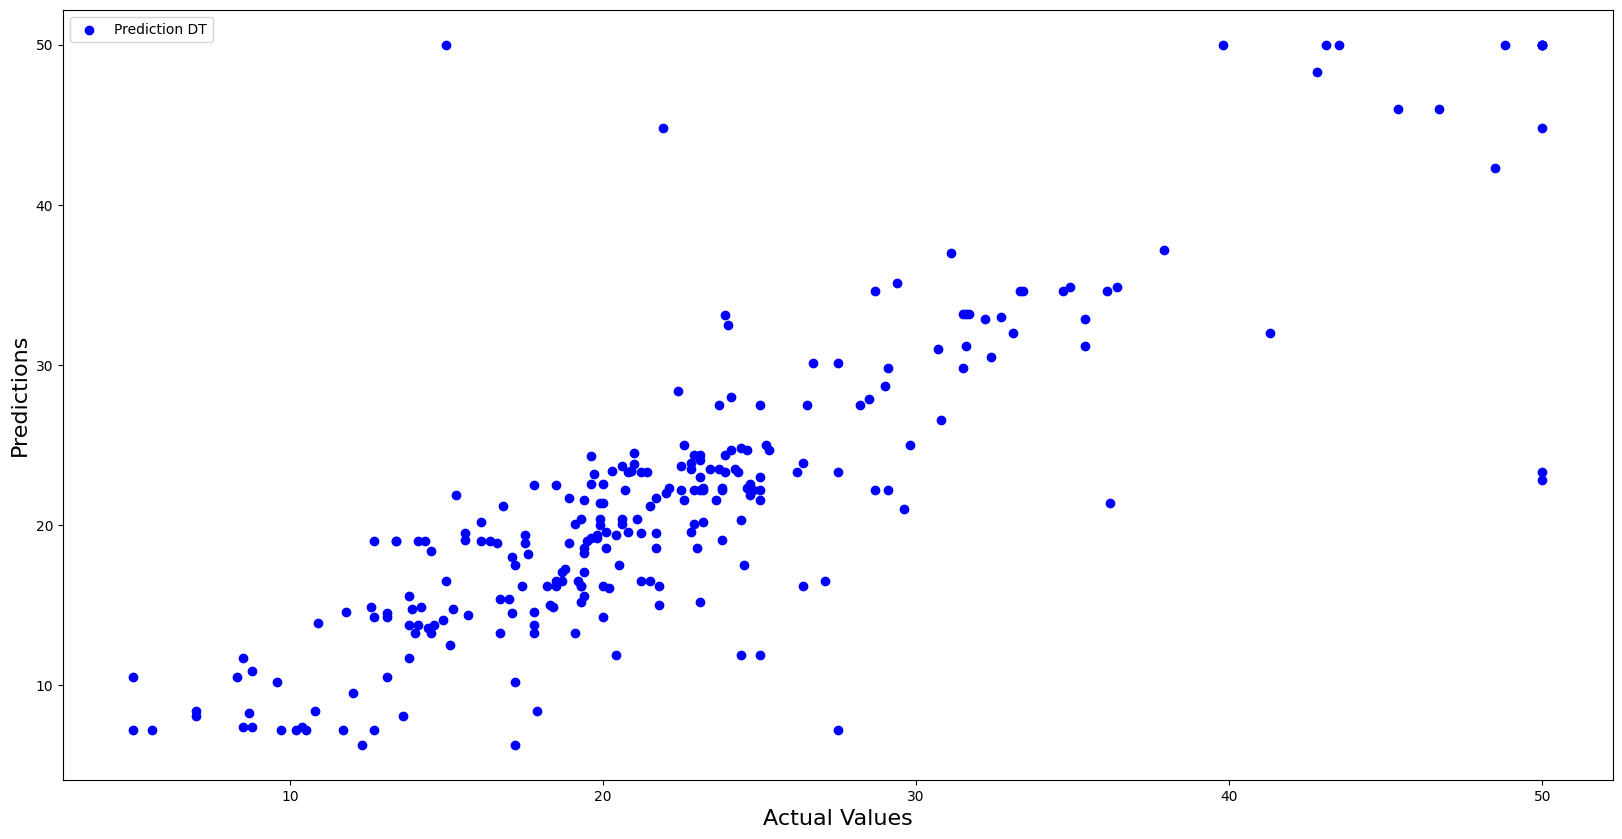

In [23]:
plt.figure(figsize=(20,10))
plt.scatter(y_test,boston_tree.predict(X_test),color='blue',label='Prediction DT')
plt.xlabel("Actual Values", fontsize=16)
plt.ylabel("Predictions", fontsize=16)
plt.legend(loc='upper left');

Now we will take a look to the tree itself. This is a bit complex since sklearn does not provide a way to visualize the models. To that end, we will need to make use of an external library: `pydotplus`.

In [32]:
# ! pip install pydotplus

# ! pip install graphviz 
# you may need to install this library directly from https://graphviz.gitlab.io/_pages/Download/Download_windows.html 
# and then uncomment following two lines

import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin\\'

"""
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'
"""
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_tree(tree, feature_names):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=feature_names,
                    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [33]:
plot_tree(boston_tree, X_train.columns)

In [35]:
# How many nodes and leaves?
print("Number of nodes: ", boston_tree.tree_.node_count)
print("Number of leaves: ", boston_tree.get_n_leaves())

Number of nodes:  479
Number of leaves:  240


Two aspects can be highlighted after taking a look at the tree:
 - The tree is huge! As we have not set any complexity pruning or max_depth we have allow the tree to grow without any limit
 - `RM` and `LSTAT` seem to be the most important features in order to predict the value of the houses. The variable `RM` measures the number of rooms (i.e., the size of the house). The tree indicates that larger houses correspond to more expensive houses. The `LSTAT` (the percentage of individuals with lower socioeconomic status) indicates that houses in expensive neighborhoods are more expensive

We can confirm this later point by plotting the feature importance

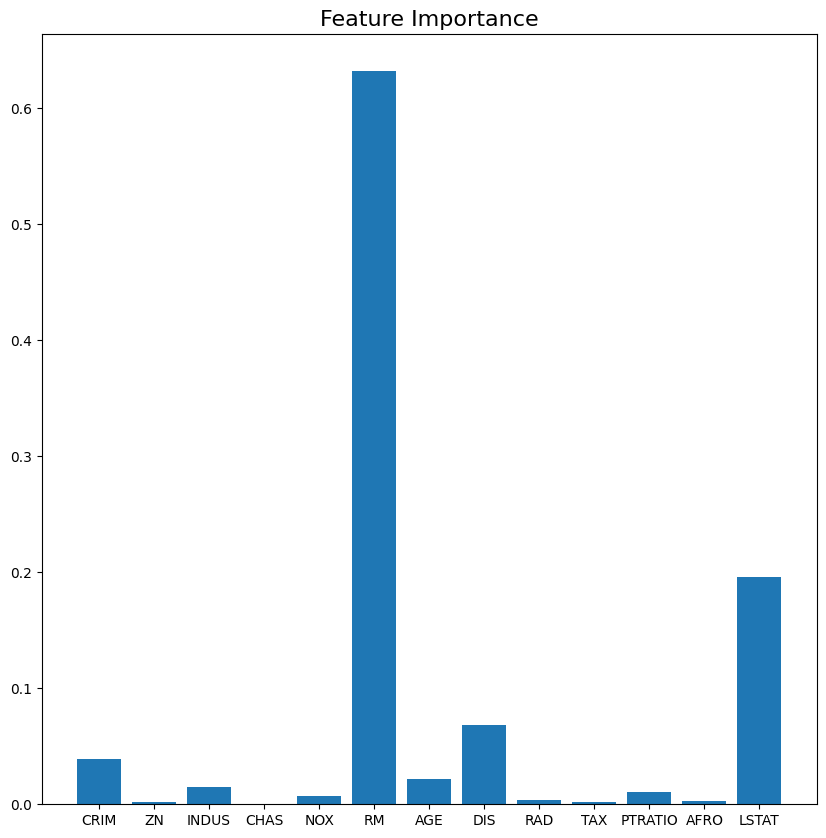

In [36]:
plt.figure(figsize=(10,10))
plt.bar(X_train.columns, boston_tree.feature_importances_)
plt.title('Feature Importance', fontsize=16);

Now we will prune the tree to see if we can improve performance.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to 30, 100, 300 or 5% of total 
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to 3, 5, 10 depending after verification on test data

Let's focus on the depth of the tree. We will test different depth thresholds via CV by using the `GridSearchCV` provided by sklearn.

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1,16)} # 15 different depth levels

boston_tree_pruned_cv = GridSearchCV(boston_tree, 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=5 , n_jobs=1, verbose=1)

boston_tree_pruned_cv.fit(X_train,y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [38]:
print("Best parameters set found on development set:")
print()
print(boston_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = boston_tree_pruned_cv.cv_results_['mean_test_score']
stds = boston_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, boston_tree_pruned_cv.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (-mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 10}

Grid scores on development set:

MSE = 51.676 (+/16.694) for {'max_depth': 1}
MSE = 29.491 (+/10.384) for {'max_depth': 2}
MSE = 24.546 (+/17.720) for {'max_depth': 3}
MSE = 23.954 (+/20.005) for {'max_depth': 4}
MSE = 23.004 (+/19.699) for {'max_depth': 5}
MSE = 22.983 (+/14.807) for {'max_depth': 6}
MSE = 24.405 (+/22.418) for {'max_depth': 7}
MSE = 26.754 (+/17.717) for {'max_depth': 8}
MSE = 24.181 (+/19.637) for {'max_depth': 9}
MSE = 21.822 (+/12.996) for {'max_depth': 10}
MSE = 26.725 (+/18.362) for {'max_depth': 11}
MSE = 24.308 (+/13.612) for {'max_depth': 12}
MSE = 23.785 (+/23.791) for {'max_depth': 13}
MSE = 24.658 (+/19.529) for {'max_depth': 14}
MSE = 23.492 (+/13.097) for {'max_depth': 15}


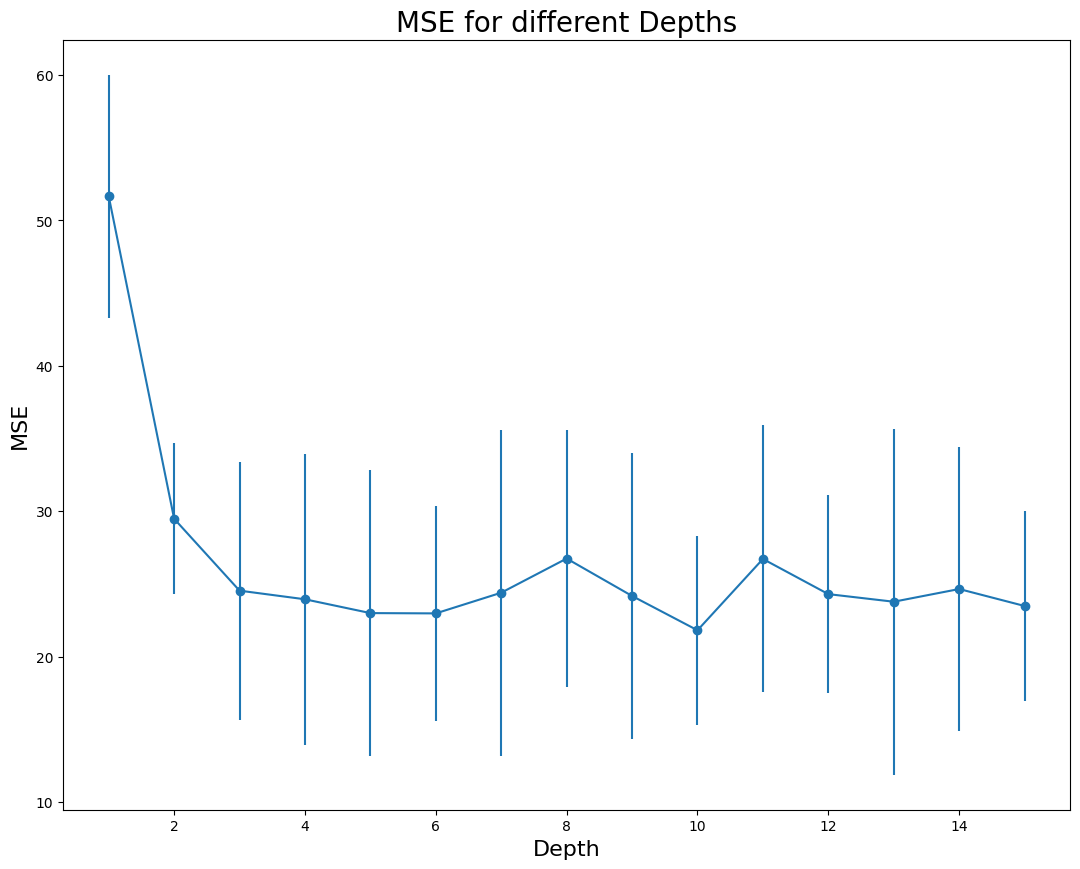

In [39]:
plt.figure(figsize=(13,10))
plt.errorbar(range(1,16,1), [-m for m in means], yerr=stds, fmt='-o')
plt.title('MSE for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("MSE", fontsize=16);

As can be seen in the plot, the optimal value for the depth of the decision tree is 9. However, we can find a local optimal at depth 6. Let's prune the tree with this value.

In [40]:
boston_tree_pruned = DecisionTreeRegressor(random_state=42, max_depth=6)
tree=boston_tree_pruned.fit(X_train, y_train)
predictions = boston_tree_pruned.predict(X_test)
print("MSE = {0:.4f}".format(mean_squared_error(y_test, predictions)))

MSE = 25.1772


Great! We have reduced the error with a smaller tree. Let's plot it

In [41]:
# How many nodes and leaves?
print("Number of nodes: ", boston_tree_pruned.tree_.node_count)
print("Number of leaves: ", boston_tree_pruned.get_n_leaves())

Number of nodes:  81
Number of leaves:  41


In [42]:
from sklearn import tree

text_representation = tree.export_text(boston_tree_pruned)
print(text_representation)
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_5 <= 6.97
|   |--- feature_12 <= 14.40
|   |   |--- feature_5 <= 6.54
|   |   |   |--- feature_7 <= 1.21
|   |   |   |   |--- value: [50.00]
|   |   |   |--- feature_7 >  1.21
|   |   |   |   |--- feature_12 <= 7.69
|   |   |   |   |   |--- feature_11 <= 351.62
|   |   |   |   |   |   |--- value: [27.00]
|   |   |   |   |   |--- feature_11 >  351.62
|   |   |   |   |   |   |--- value: [23.35]
|   |   |   |   |--- feature_12 >  7.69
|   |   |   |   |   |--- feature_12 <= 7.89
|   |   |   |   |   |   |--- value: [15.25]
|   |   |   |   |   |--- feature_12 >  7.89
|   |   |   |   |   |   |--- value: [21.02]
|   |   |--- feature_5 >  6.54
|   |   |   |--- feature_12 <= 5.78
|   |   |   |   |--- feature_10 <= 17.85
|   |   |   |   |   |--- feature_12 <= 4.77
|   |   |   |   |   |   |--- value: [30.72]
|   |   |   |   |   |--- feature_12 >  4.77
|   |   |   |   |   |   |--- value: [34.87]
|   |   |   |   |--- feature_10 >  17.85
|   |   |   |   |   |--- feature_7 <= 4.22
|   |  

### Tree visualizations

We are going to deep down a bit more on the tree.<BR>


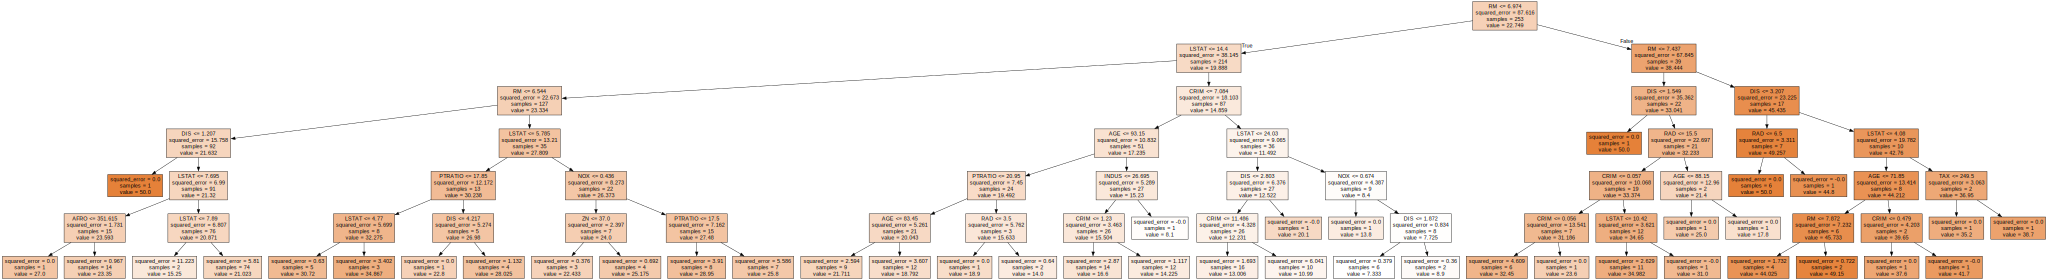

In [43]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(boston_tree_pruned, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [44]:
# Save it into a high resolution image
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

Another option:
we need to install the powerful library *dtreeviz* for this

In [47]:
# ! pip install dtreeviz
import dtreeviz

viz_cmodel = dtreeviz.model(boston_tree_pruned,
                           X_train=X_train,
                           y_train=y_train,
                           feature_names=X_train.columns,
                           target_name='MEDV')
v=viz_cmodel.view(scale=1)
v.show()                 
v.save("dtreeviz.svg")

c:\Users\prama\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


What is the tree root node?

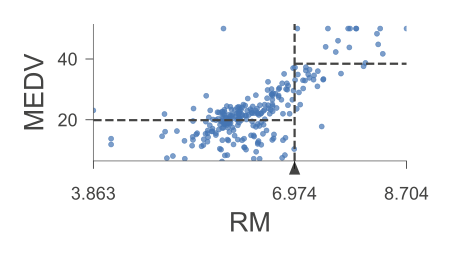

In [48]:
viz_cmodel.view(depth_range_to_display=[0,0], scale=3)

Display now 3 levels (0, 1 & 2)

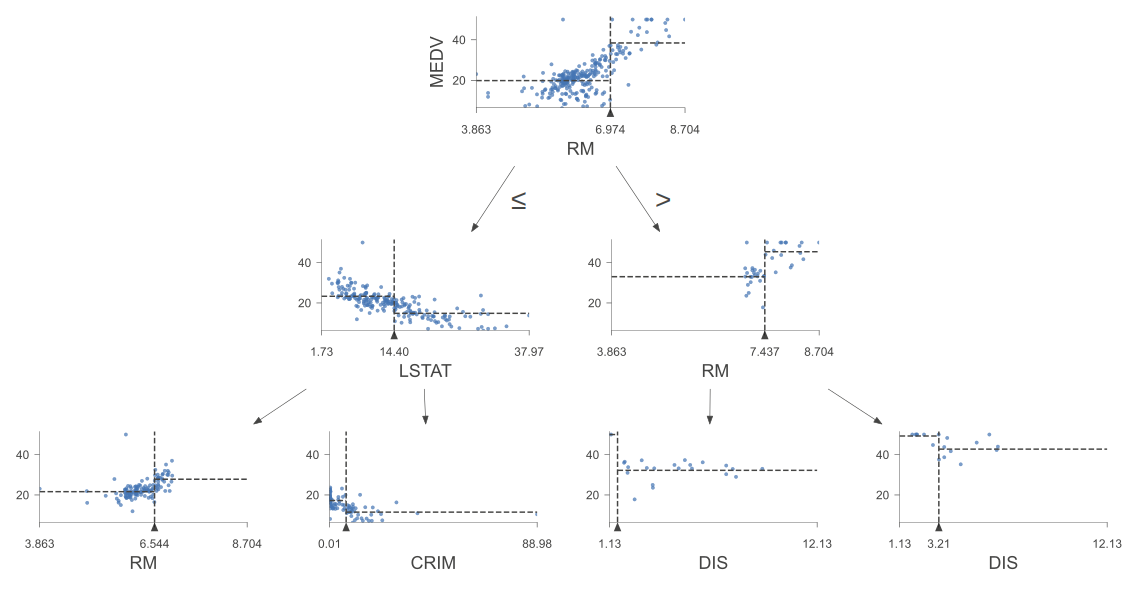

In [49]:
viz_cmodel.view(depth_range_to_display=[0,2], scale=2)

Change orientation (for big trees sometimes is preferred)

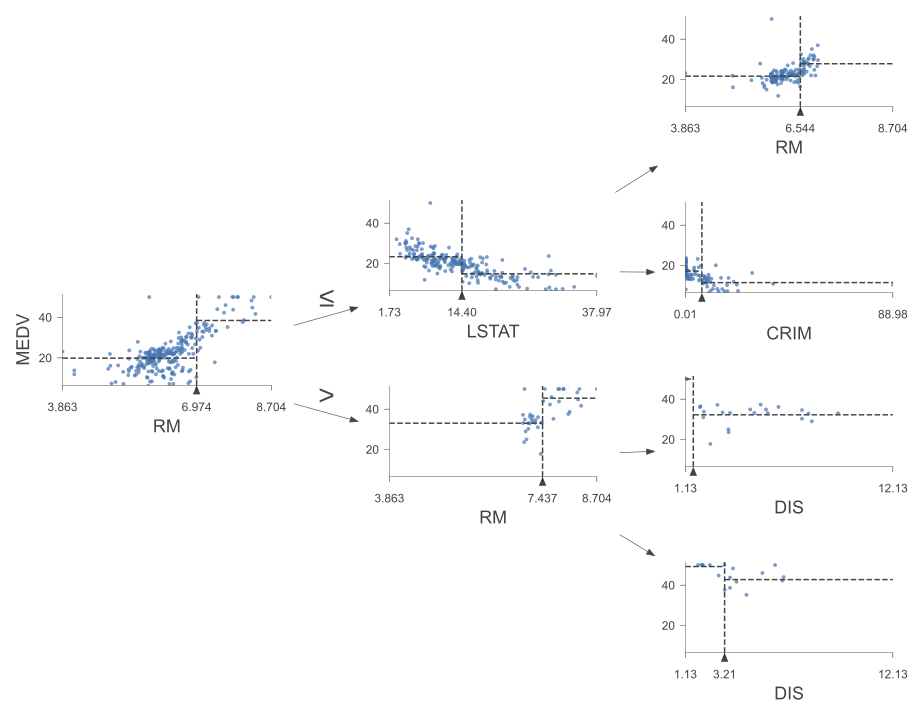

In [50]:
viz_cmodel.view(orientation='LR', depth_range_to_display=[0,2], scale=2)

Display now frequencies for each node.<BR>
We can see node id=11 is the one with maximum amount of people

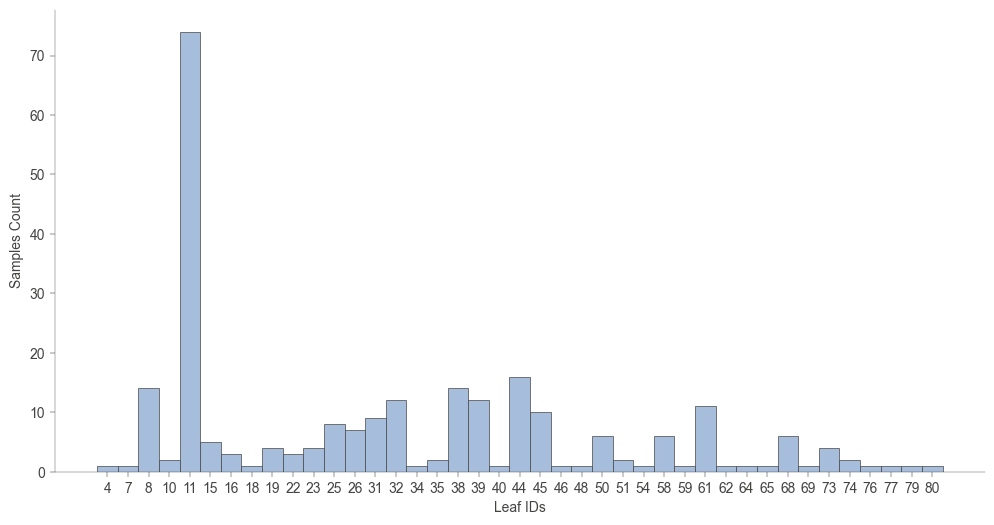

In [51]:
viz_cmodel.leaf_sizes(figsize=(12,6))

Let's explore that node

In [52]:
viz_cmodel.node_stats(node_id=11)

CRIM         ZN      INDUS      CHAS       NOX        RM  \
count      74.0       74.0       74.0      74.0      74.0      74.0   
mean   2.349067   5.878378  10.861081  0.054054  0.536107  6.003486   
std    6.604037  16.090457   6.252217  0.227668  0.095628  0.387313   
min     0.01096        0.0       1.76       0.0     0.385     3.863   
25%     0.06962        0.0      5.695       0.0     0.461   5.88875   
50%    0.229225        0.0      9.795       0.0      0.52    6.0165   
75%     2.05585        0.0       18.1       0.0    0.5845   6.20225   
max     51.1358       80.0      25.65       1.0     0.871      6.54   

             AGE       DIS       RAD         TAX    PTRATIO        AFRO  \
count       74.0      74.0      74.0        74.0       74.0        74.0   
mean        63.1  4.078592  8.094595  376.527027  18.627027  370.633378   
std    23.770968  1.937238  8.193163  157.297835   1.831782   66.988848   
min         17.5    1.2852       1.0       188.0       14.7         2.6   
25%       42.875  2.565025       4.0      276.25     17.025    378.7675   
50%        63.85   3.69775       4.0       304.5       18.6     392.665   
75%       83.925  5.269125       6.0      417.25       20.2    396.0625   
max        100.0   10.5857      24.0       666.0       22.0       396.9   

           LSTAT  
count       74.0  
mean   11.255135  
std     1.904688  
min          7.9  
25%         9.65  
50%        11.27  
75%      12.9275  
max        14.37

And highlight it in the tree so that we can take a closer look at it

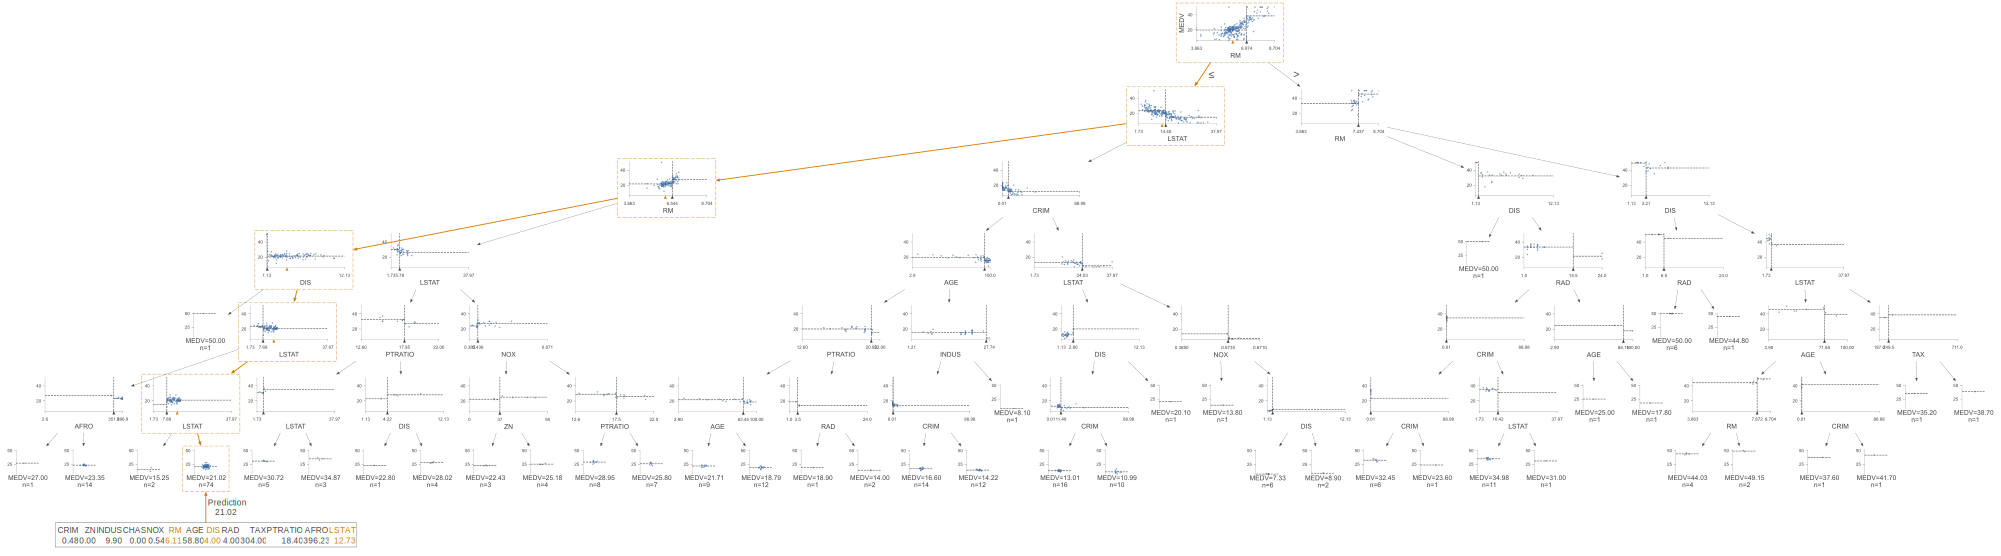

In [53]:
x = X_train[X_train.columns].iloc[201]
viz_cmodel.view(x=x, scale=.75)

Zoom it

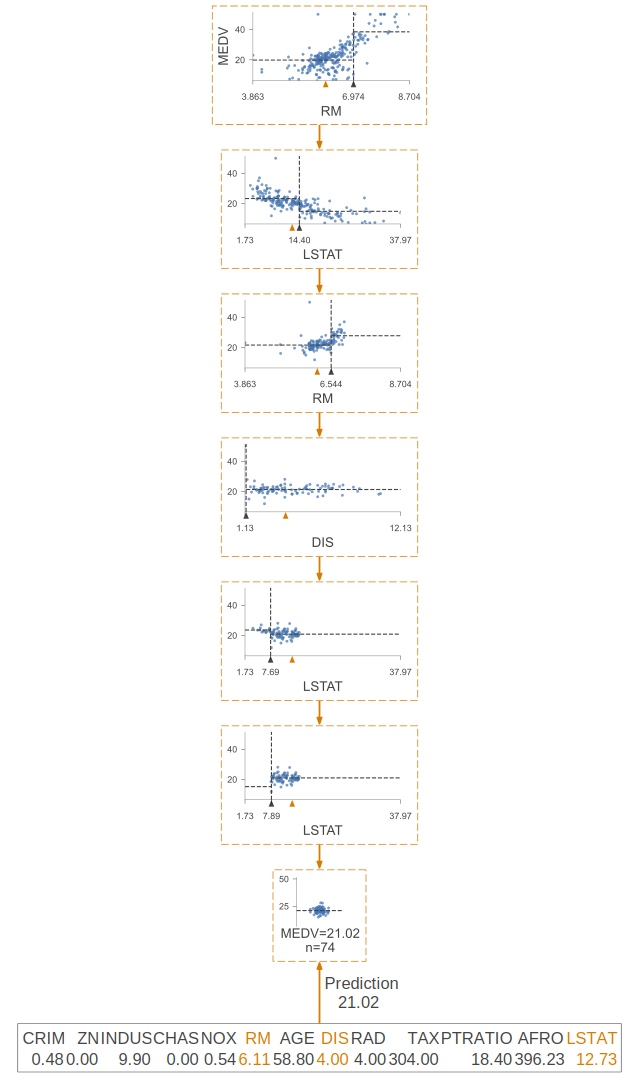

In [54]:
viz_cmodel.view(x=x, show_just_path=True, scale=1.5)

What is the tree root node?

In [55]:
print(viz_cmodel.explain_prediction_path(x=x))

RM < 6.54
1.21 <= DIS 
7.89 <= LSTAT  < 14.4



What is the tree root node?

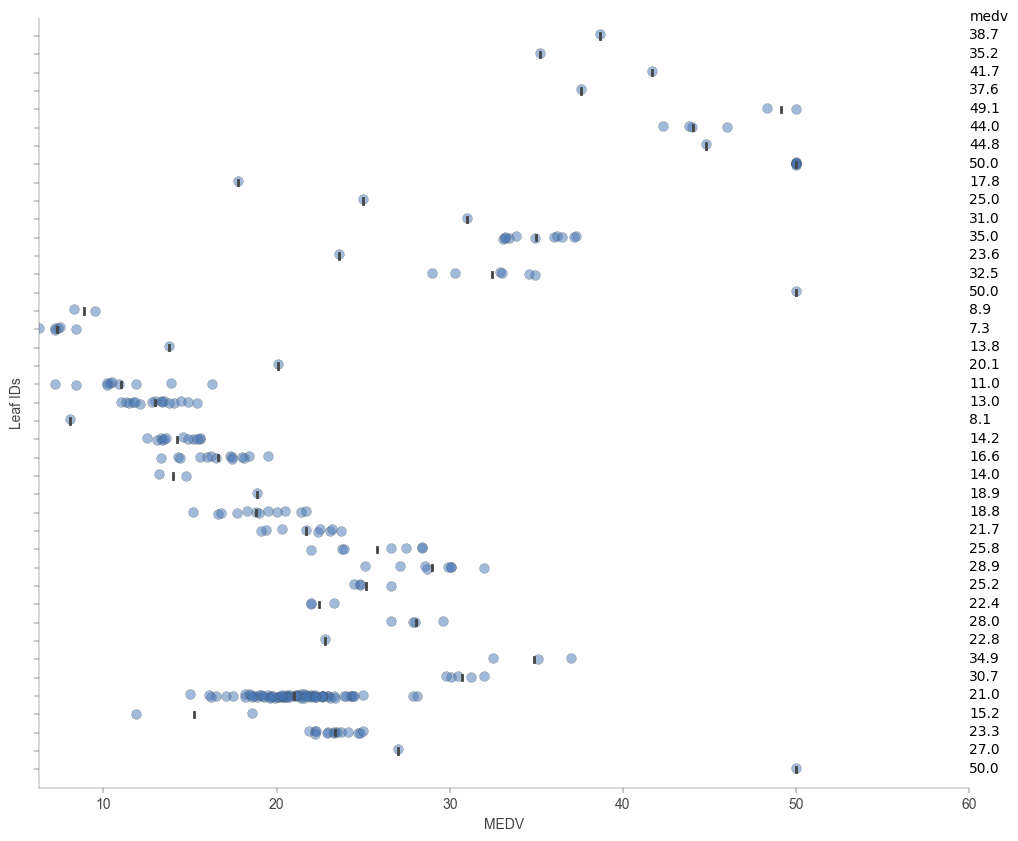

In [56]:
viz_cmodel.rtree_leaf_distributions(figsize=(12,10))